# Evaluation

In [1]:
import json
import os

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

## Summary Length

In [2]:
directory = "./evaluation/summary/"

evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "output_uri", "violation_actual", "violation_predicted", "summary_old", "length_old", "summary_new", "length_new", "correction_in_range"])

actual = np.array([])
predicted = np.array([])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    outputUri = directory + filename

    with open(outputUri) as f:
        result = json.load(f)
    
    actual = np.append(actual, result["violation_actual"])
    predicted = np.append(predicted, result["output"]["violation_predicted"])

    if (len(result["output"]["summary_new"]) <= 70) & (len(result["output"]["summary_new"]) >= 39):
        in_range = "TRUE"
    else:
        in_range = "FALSE"

    new_row = {
        'jira': result["input_data"]["jira"], 
        'ticketId': result["input_data"]["id"], 
        'evolution': result["input_data"]["evolution"], 
        'output_uri': outputUri, 
        'violation_actual': result["violation_actual"], 
        'violation_predicted': result["output"]["violation_predicted"],
        'summary_old': result["output"]["summary_old"],
        'length_old': len(result["output"]["summary_old"]), 
        'summary_new': result["output"]["summary_new"],
        'length_new': len(result["output"]["summary_new"]), 
        'correction_in_range': in_range
        }

    evalDF.loc[len(evalDF)]=new_row

# Save data to csv
evalDF.to_csv("./evaluation/evaluatedSummarys.csv", index=False)

#### Detection

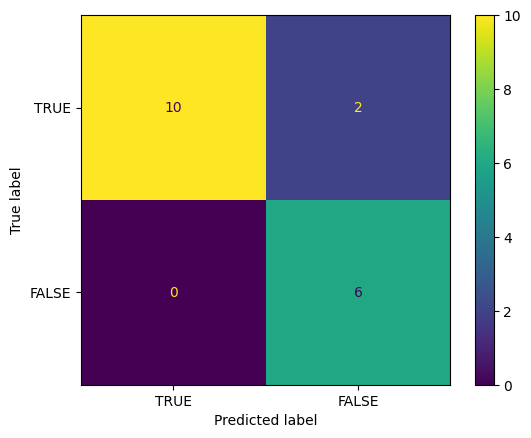

In [3]:
accuracy = metrics.accuracy_score(actual, predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=["TRUE", "FALSE"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["TRUE", "FALSE"])

cm_display.plot()
plt.show()

In [ ]:
print("Accuracy: " + str(accuracy))

#### Correction

In [4]:
successRate = evalDF["correction_in_range"].value_counts(normalize=True)["TRUE"]

In [5]:
print("Success rate: " + str(successRate))

Accuracy: 0.8888888888888888
Success rate: 0.8333333333333334


In [6]:
evalDF

,jira,ticketId,evolution,output_uri,violation_actual,violation_predicted,summary_old,length_old,summary_new,length_new,correction_in_range
0,Qt,187366,0,./evaluation/summary/output_2024-02-16_11:45:1...,FALSE,FALSE,looks like a bug: can never load qt jpeg plugi...,67,looks like a bug: can never load qt jpeg plugi...,67,TRUE
1,Qt,206925,0,./evaluation/summary/output_2024-02-16_11:47:0...,TRUE,FALSE,Different build configurations should remember...,72,Different build configurations should remember...,72,FALSE
2,Jira,151397,0,./evaluation/summary/output_2024-02-16_11:21:5...,TRUE,TRUE,Show the login screen when user attempts to cr...,80,Redirect to login screen for unauthenticated i...,59,TRUE
3,Qt,322707,0,./evaluation/summary/output_2024-02-16_11:50:2...,FALSE,FALSE,Inequality sign in Photoshop text layer isn't ...,64,Inequality sign in Photoshop text layer isn't ...,64,TRUE
4,RedHat,12551075,0,./evaluation/summary/output_2024-02-16_11:52:1...,TRUE,TRUE,Sansa doesn't have Ant installed,32,Jenkins node Sansa is missing Ant installation...,58,TRUE
5,RedHat,13202675,0,./evaluation/summary/output_2024-02-16_11:54:2...,TRUE,TRUE,"As a user of Quay Operator, I want to be able ...",85,Enable scaling of mirroring Pod in TNG Operator,47,TRUE
6,RedHat,13259062,0,./evaluation/summary/output_2024-02-16_11:54:5...,FALSE,FALSE,Remove dryRunOpts import from console package,45,Remove dryRunOpts import from console package,45,TRUE
7,Jira,33094,0,./evaluation/summary/output_2024-02-16_11:21:1...,TRUE,TRUE,Thumbnail problem,17,Error viewing Thumbnail demo page due to lack ...,66,TRUE
8,Jira,78993,0,./evaluation/summary/output_2024-02-15_16:42:3...,TRUE,TRUE,write ajax action,17,Development Sub-task: Write AJAX action for Cr...,76,FALSE
9,Qt,234192,0,./evaluation/summary/output_2024-02-16_11:48:5...,TRUE,TRUE,Typo in documentation,21,Typo correction needed on Qt's cmake-manual do...,62,TRUE
